In [52]:
audio_path = "audio-data/sweep.mp3"
name = "sweep-mfccs"

# segmentation
block_length = 1 # number of frames in a stream block
BPM = None
beat = None # metered divisions
# hop_beats = 1 / 8 # hop length in beats
## alternatively, you can specify frame length and hop length in seconds
frame_length_s = 0.1
hop_length_s = 0.02
## or in samples
# frame_length = 4096
# hop_length = 1024

# feature extraction
extract_crude = False
extract_spectral = False
extract_mfccs = True

# clustering
n_classes = 64 # number of clusters to form with KMeans

# model architecture and training
maxlen = 256
step = 1 # step size for sliding window
hidden_units = 48 # number of hidden units in GRU layer
epochs = 50
batch_size = 32
validation_split = 0.2
early_stopping = False
checkpoint = True
patience = 5 # number of epochs to wait before early stopping

# utility
verbose = 1 # print additional information
directory = "."

In [53]:
# import dependencies
import argparse
from pathlib import Path
import math
import numpy as np, matplotlib.pyplot as plt, librosa
import matplotlib.ticker as mticker
import librosa.display
# import IPython.display
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import json
from numpyencoder import NumpyEncoder
from sklearn import preprocessing, cluster
from streamer import Streamer
import scipy
from keras.utils import to_categorical
from keras import Sequential
import pickle

if BPM is None and beat is not None or BPM is not None and beat is None:
    print("Please specify both BPM and beat if you are using metered divisions.")
    exit()
frame_length_s = (4 * beat * 60 / BPM) if BPM is not None else frame_length_s
hop_length_s = (4 * hop_beats * 60 / BPM) if BPM is not None else hop_length_s
sr = librosa.get_samplerate(audio_path)
frame_length = math.ceil(frame_length_s * sr) if frame_length_s is not None else frame_length
hop_length = math.ceil(hop_length_s * sr) if hop_length_s is not None else hop_length
stream = Streamer(audio_path, block_length, frame_length, hop_length)
path = Path(directory + "/models/" + name)
path.mkdir(exist_ok=True, parents=True)

In [54]:
# helper function to extract features from audio block
def extract_features(y, sr, extract_crude=True, extract_spectral=False, extract_mfccs=False):
    if extract_crude:
        zcr = [librosa.zero_crossings(y).sum()]
        energy = [scipy.linalg.norm(y)]
    if extract_spectral:
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_flatness = librosa.feature.spectral_flatness(y=y)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        m_centroid = np.median(spectral_centroid, axis=1)
        m_bandwith = np.median(spectral_bandwith, axis=1)
        m_flatness = np.median(spectral_flatness, axis=1)
        m_rolloff = np.median(spectral_rolloff, axis=1)
    if extract_mfccs:        
        if y.size >= 2048:  
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False) # mfccs
        else:
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
        m_mfccs = np.median(mfccs[1:], axis=1)
    features = np.array([])
    if extract_crude:
            features = np.concatenate((
            features,
            zcr,
            energy
    ))
    if extract_spectral:
        features = np.concatenate((
            features,
            m_centroid,
            m_bandwith,
            m_flatness,
            m_rolloff
        ))
    if extract_mfccs:
        features = np.concatenate((
            features,
            m_mfccs
        ))
    if len(features) == 0:
        return None
    return features

Audio length: 128.016s, 6144768 samples
Sample rate: 48000 Hz
Frame length: 0.1s,  4800 samples
Hop length: 0.02s, 960 samples
Block length: 1 frame(s)
Number of blocks: 6401
(6397, 12)
(6397, 12)
[-1.49822518 -2.13804379 -3.04472851 -1.6242315  -1.82076304 -1.96513819
 -2.00321757 -1.88965393 -1.47091398 -1.28580001 -1.28759062 -1.79986864]
[1.60052587 3.75236329 1.37908781 1.54258949 1.64387713 1.68808253
 2.77712028 3.71442152 3.53104814 3.07507572 2.96106915 3.0229784 ]
[1.5397024  3.75236329 0.28099751 1.54258949 1.31681879 1.68808253
 1.70344854 0.99700335 0.73026429 0.13918712 0.38777226 0.15458572]


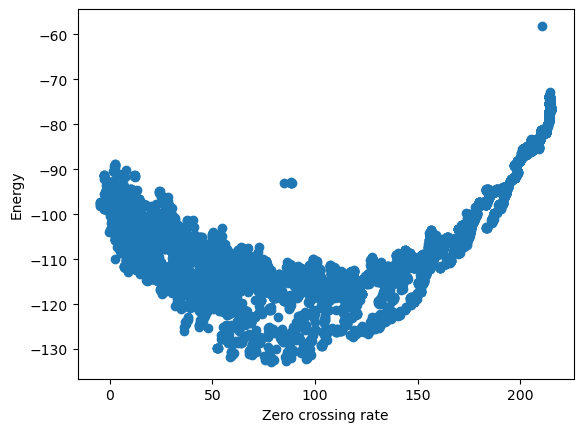

In [55]:
print(f"Audio length: {stream.length}s, {stream.n_samples} samples")
print(f"Sample rate: {sr} Hz")
print(f"Frame length: {frame_length_s}s,  {frame_length} samples")
print(f"Hop length: {hop_length_s}s, {hop_length} samples")
print(f"Block length: {block_length} frame(s)")
print(f"Number of blocks: {len(stream)}")

# extract features from each block in audio stream
features = np.array([extract_features(block, sr, extract_crude=extract_crude, extract_spectral=extract_spectral, extract_mfccs=extract_mfccs) for block in stream.new()])
# features_scaled = features
features_scaled = preprocessing.scale(features, axis=0) # should it be axis 0 then not 1??
if verbose:
    # print(features[0])
    print(features.shape)
    print(features_scaled.shape)
    print(features_scaled.min(axis=0))
    print(features_scaled.max(axis=0))
    print(features_scaled[0]) # type: ignore
if verbose:
    plt.scatter(features[:,0], features[:,1], ) # type: ignore
    plt.xlabel('Zero crossing rate')
    plt.ylabel('Energy')   
    plt.show()
    # plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    # plt.show()

In [56]:
features[0]

array([210.75874329, -58.10147858,  62.30374908,  -1.01372266,
         3.37199783,  18.44295311,  -5.71353245,   8.42777443,
        -0.48879886,   1.5136404 ,   0.98064518,   0.47583324])

In [57]:
# cluster features
# frames = [frame for frame in frames if frame.size != 0] # remove empty
c_model = cluster.KMeans(n_clusters=n_classes, n_init='auto')
labels = c_model.fit_predict(features_scaled)

/var/folders/kt/3yzrdbd548lfc1w4yd4phlwm0000gn/T/ipykernel_9852/4173866377.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_classes)


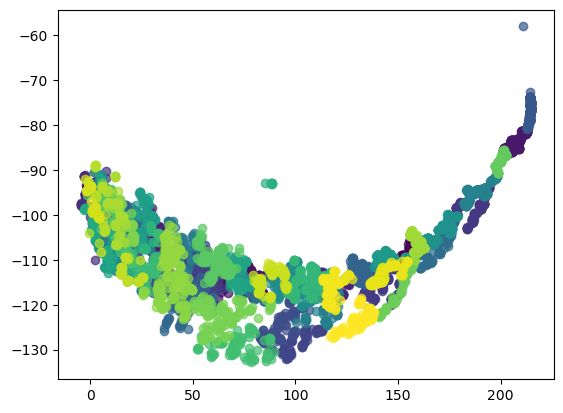

In [58]:
# Define a color map for the clusters
cmap = plt.cm.get_cmap('viridis', n_classes)

# Plot the data points with colors corresponding to their labels and add labels to legend
for i in range(n_classes):
    plt.scatter(features[labels==i, 0], features[labels==i, 1], color=cmap(i), alpha=0.7, label='Class {}'.format(i+1))
# plt.legend()
plt.savefig(path / (name + "_clusters.png"))
plt.show()

In [59]:
n_labels = len(np.unique(labels))
labels = labels.tolist()
if verbose:
    print(f"Total labelled frames: {len(labels)}")
    print(f"n_labels: {n_labels} (sanity check)")

frames = []
for i, block in enumerate(stream.new()):
    frames.append([i * hop_length, i * hop_length + frame_length])
# frames # sanity check

# each dict value has to be a 1D interlaved array, as Max dict object has trouble reading 2D arrays
# start sample is always stored at an even index and is followed by end sample
labelled_frames = dict()
for label, frame in zip(labels, frames):
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].extend(frame) # use extend instead of append
if verbose:    
    print(len(labelled_frames[0])) # sanity check
    print(labelled_frames[0][0], labelled_frames[0][1]) # sanity check

# build a subsequence for every <step> frames
# and a corresponding label that follows it
x = [] # these will be features
y = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    x.append(labels[i: i + maxlen])
    y.append(labels[i + maxlen])
# x_ = np.array(features)
# y_ = np.array(targets)
# one-hot encode features and targets
x_ = to_categorical(x, dtype ="bool")
y_ = to_categorical(y, dtype ="bool")
# sanity check
if verbose:
    print(x_.shape)
    print(y_.shape)

Total labelled frames: 6397
n_labels: 64 (sanity check)
92
631680 636480
(6141, 256, 64)
(6141, 64)


In [60]:
model_path = path / (name + ".keras")

In [61]:
# adapted from code by Lukas Biewald
# https://github.com/lukas/ml-class/blob/master/projects/7-text-generation/char-gen.py
inputs = Input(shape=(maxlen, n_labels))
x = GRU(hidden_units)(inputs)
outputs = Dense(n_labels, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model._name = name
callbacks = []
if early_stopping:
    callbacks.append(EarlyStopping(
        monitor='val_loss',
        patience=patience
    ))
if checkpoint:
    callbacks.append(ModelCheckpoint(
        filepath=model_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    ))
model.compile(
    loss='categorical_crossentropy', # since we are using one-hot encoded labels
    optimizer="adam",
    metrics=['accuracy']
    )
model.summary()

history = model.fit(
    x_,
    y_,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=0.2,
    callbacks=callbacks
)

Model: "sweep-mfccs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 64)]         0         
                                                                 
 gru_4 (GRU)                 (None, 48)                16416     
                                                                 
 dense_4 (Dense)             (None, 64)                3136      
                                                                 
Total params: 19,552
Trainable params: 19,552
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
154/154 [==============================] - 6s 34ms/step - loss: 3.8033 - accuracy: 0.4074 - val_loss: 3.4115 - val_accuracy: 0.5069
Epoch 2/50
154/154 [==============================] - 5s 31ms/step - loss: 2.7031 - accuracy: 0.6164 - val_loss: 2.2297 - val_accuracy: 0.6835
Epoch 3/50
154/154 [=========

In [62]:
print(f"Saved model to: {path}")
d_path = path / (name + "_frames.json")
d_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
config = dict()
config["filename"] = audio_path.split('/')[-1]
config["sr"] = sr
config["BPM"] = BPM
config["beat"] = beat
config["n_classes"] = int(n_classes)
config["maxlen"] = int(maxlen)
config["onset_detection"] = False
config["hop_length"] = hop_length
config["frame_length"] = frame_length
config["block_length"] = block_length
c_path = path / (name + "_config.json")    
c_path.write_text(json.dumps(config))
if verbose:
    print(f"Saved model to: {model_path}")
    print(f"Saved frames to: {d_path}")
    print(f"Saved config to: {c_path}")

Saved model to: models/sweep-mfccs
Saved model to: models/sweep-mfccs/sweep-mfccs.keras
Saved frames to: models/sweep-mfccs/sweep-mfccs_frames.json
Saved config to: models/sweep-mfccs/sweep-mfccs_config.json


In [63]:
history = history.history
h_path = path / (name + "_history")
with open(h_path, 'wb') as file_pi:
    pickle.dump(history, file_pi)
if verbose:
    print(f"Saved history to: {h_path}")

Saved history to: models/sweep-mfccs/sweep-mfccs_history


In [64]:
# with open(h_path, "rb") as file_pi:
#     history = pickle.load(file_pi)

In [65]:
print(f"Total epochs : {len(history['loss'])}")
print("Minimum validation loss: ", min(history['val_loss']), "\nEpoch: ", np.argmin(history['val_loss']))
print("Maximum validation accuracy: ", max(history['val_accuracy']), "\nEpoch: ", np.argmax(history['val_accuracy']))

Total epochs : 50
Minimum validation loss:  0.35162973403930664 
Epoch:  42
Maximum validation accuracy:  0.8714401721954346 
Epoch:  42


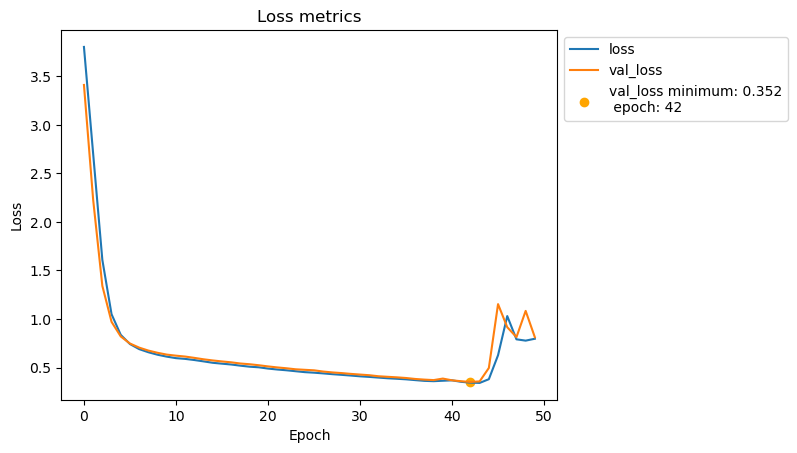

In [66]:
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
vl_min = min(history['val_loss'])
vl_min_epoch = np.argmin(history['val_loss'])
plt.scatter(vl_min_epoch, vl_min,c='orange', label=f'val_loss minimum: {vl_min:.3f}\n epoch: {vl_min_epoch}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Loss metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.tight_layout()
plt.savefig(path / (name + "_loss.png"), bbox_inches='tight')
plt.show()

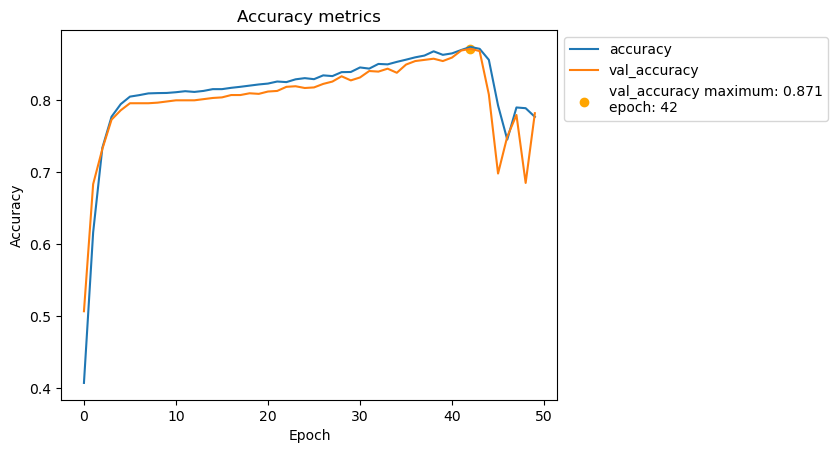

In [67]:
plt.plot(history["accuracy"], label="accuracy")
plt.plot(history["val_accuracy"], label="val_accuracy")
va_max = max(history['val_accuracy'])
va_max_epoch = np.argmax(history['val_accuracy'])
plt.scatter(va_max_epoch, va_max,c='orange', label=f'val_accuracy maximum: {va_max:.3f}\nepoch: {va_max_epoch}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Accuracy metrics")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(path / (name + "_accuracy.png"), bbox_inches='tight')
plt.show()